## USDE Project: A simple example of RNN 

Suppose there is a pub in which every day it is served only one type of food. The possible types of food are three and are: apple pie, burger and chicken. <br>
We want to build an algorithm capable to predict the course of the next day basing on the time series of the courses in the previous days. To do so, we will use a recurrent neural network. <br>
In particular, we invent a deterministic law that establish the dish for the next day and then we check if our network is able to learn this rule. <br>
Suppose the rule is the following: <br>
1)	the courses alternate following this specific order: apple pie, burger and chicken <br>
2)	The weather can be sunny or rainy. If it is sunny, the course for the next day remains the same, otherwise it changes. <br>
The situation is synthetized in the picture. 
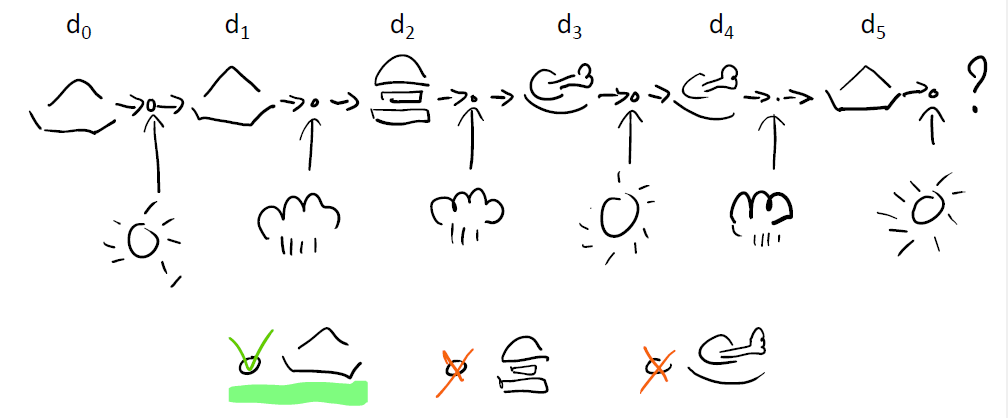

First of all, I generate the time series

In [2]:
# I import the required libraries 
import pandas as pd
import random

n = 800 # number of days in the time series
seed = 10 # for reproducibility, I set the seed
random.seed(seed)
time_series = [['apple pie', 'sunny']] # I set the weather and the course for the first day

for i in range(n): # I generate the data for the other days
    
    # if the previous days was rainy, I change the course following the order
    if time_series[i][1]=='rainy':
        if time_series[i][0]=='apple pie':
            course = 'burger'
        elif time_series[i][0]=='burger':
            course = 'chicken'
        else:
            course = 'apple pie'
            
    # otherwise, the course remains the same
    else:
        course = time_series[i][0]
    
    # I set randomly the weather for the day
    rand = random.randint(0,1)
    if rand==0:
        weather = 'sunny'
    else:
        weather = 'rainy'
        
    # I add the day to the time series
    time_series.append([course, weather])
    
# finally, I create a pandas dataframe
df = pd.DataFrame(time_series, columns=['Course', 'Weather'])
df

,Course,Weather
0,apple pie,sunny
1,apple pie,sunny
2,apple pie,rainy
3,burger,rainy
4,chicken,sunny
...,...,...
796,burger,rainy
797,chicken,sunny
798,chicken,sunny
799,chicken,sunny


I have the time series in a Pandas dataframe in which the index represents the day. <br>
Now the goal is to train a neural network to forecast the course of the next day. This is a classification problem for time series, in which the possible labels are the three courses. <br>
In order to train the neural network, it is first necessary to pre-process the data with a proper encoding of the features. <br>
“Weather” is a binary variable, so it is sufficient to encode the labels “sunny” and “rainy” with “0” and “1”. <br>
Concerning “Course”, I can proceed with label encoding or one-hot encoding. Label encoding consists of mapping the labels to integer numbers and it is the right choice when dealing with ordered variables. In our example, we know that there is an order relation in the labels. However, this order is part of the “ground truth” that we want our algorithm to learn and we must consider it unknown a priori. <br>
For this reason, we will proceed with one-hot encoding, that is suitable for more general situation


In [3]:
df_encoded = pd.get_dummies(df.Course, prefix='Course')            # one-hot encoding for variable "Course"

df_encoded['Weather'] = df['Weather'].astype('category').cat.codes # I add to "df_encoded" the label encoding of the 
                                                                   # binary variable "Weather"
df_encoded

,Course_apple pie,Course_burger,Course_chicken,Weather
0,1,0,0,1
1,1,0,0,1
2,1,0,0,0
3,0,1,0,0
4,0,0,1,1
...,...,...,...,...
796,0,1,0,0
797,0,0,1,1
798,0,0,1,1
799,0,0,1,1


Now I proceed with the actual training of the neural network. <br>
First of all, I have to decide the number of time steps to be taken into account by the algorithm for its predictions. We know that the course of the day is deterministically determined by the course and the weather of the previous day, but, again, this is the ground truth and it is not known a priori. <br>
A reasonable choice for the problem would be taking into account all the days of the previous week. <br>
I put the pre-processed data in a Numpy array and in another one the associated targets labels. Then, on these arrays, I will run a Keras function to create the various temporal windows to train the network. 

In [4]:
import numpy as np 

past_days = 7 # I set the number of days the algorithm will use for the predicitons 

input_data = np.array(df_encoded)[:-past_days] # I revome from the dataset the last n=past_days days 
                                               # (for them I don't have the labels to predict)
    
targets = np.array(df_encoded.drop('Weather', axis=1))[past_days:] # I create the targets array
                                                                   # removing the first n=past_days days
                                                                   # (for them I don't have all the information required 
                                                                   # to make predictions)

Now I can run the Keras pre-processing function on the arrays. <br> 
I also divide the data in training and validation set. I will use the validation set to decide when to stop the iterations of gradient descent and to see how the algorithm behave with data that weren’t use for the training (being a simple deterministic rule, we would like to obtain the 100% accuracy on both the sets). <br>
As in common use, I will reserve 70% of the data for training set and 30% for validation set

In [5]:
import tensorflow as tf

valid_limit = round(n*0.70)

dataset = tf.keras.preprocessing.timeseries_dataset_from_array(input_data[:valid_limit], targets[:valid_limit], sequence_length=past_days)
dataset_valid = tf.keras.preprocessing.timeseries_dataset_from_array(input_data[valid_limit:], targets[valid_limit:], sequence_length=past_days)

Now I create the network. Being a simple task, I will use only two layers: <br>
-	A simpleRNN layer with 32 neurons, that is the simplest structure endowed with memory cells <br>
-	A final layer with softmax activation function, being our task a classification problem <br>

This is an extremely simple network with only 1283 parameters, but it should be enough for our problem. 


In [9]:
#Recurrent Neural Network

num_classes = 3
num_features = 4

model = tf.keras.models.Sequential([
    # Shape [batch, time, features]
    tf.keras.Input(shape=(past_days, num_features)),
    tf.keras.layers.SimpleRNN(32), 
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

I set the ultimate settings for the training: the learning rate and the metrics I will use to monitor the learning and stop the gradient descent before overfitting. 

In [7]:
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']

# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1184      
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 1,283
Trainable params: 1,283
Non-trainable params: 0
_________________________________________________________________


Finally, I proceed with the training 

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(dataset, validation_data=dataset_valid, epochs=500, callbacks=[early_stopping])

Epoch 1/500
5/5 [==============================] - 2s 140ms/step - loss: 1.1694 - accuracy: 0.3974 - val_loss: 1.1595 - val_accuracy: 0.3465
Epoch 2/500
5/5 [==============================] - 0s 33ms/step - loss: 1.1213 - accuracy: 0.3622 - val_loss: 1.1280 - val_accuracy: 0.3377
Epoch 3/500
5/5 [==============================] - 0s 34ms/step - loss: 1.0871 - accuracy: 0.3554 - val_loss: 1.0994 - val_accuracy: 0.3246
Epoch 4/500
5/5 [==============================] - 0s 35ms/step - loss: 1.0582 - accuracy: 0.3574 - val_loss: 1.0730 - val_accuracy: 0.3465
Epoch 5/500
5/5 [==============================] - 0s 33ms/step - loss: 1.0325 - accuracy: 0.3993 - val_loss: 1.0499 - val_accuracy: 0.3596
Epoch 6/500
5/5 [==============================] - 0s 35ms/step - loss: 1.0096 - accuracy: 0.4142 - val_loss: 1.0301 - val_accuracy: 0.3640
Epoch 7/500
5/5 [==============================] - 0s 33ms/step - loss: 0.9890 - accuracy: 0.4263 - val_loss: 1.0130 - val_accuracy: 0.3860
Epoch 8/500
5/5 [==

Epoch 59/500
5/5 [==============================] - 0s 34ms/step - loss: 0.6326 - accuracy: 0.6649 - val_loss: 0.6955 - val_accuracy: 0.6447
Epoch 60/500
5/5 [==============================] - 0s 32ms/step - loss: 0.6285 - accuracy: 0.6636 - val_loss: 0.6923 - val_accuracy: 0.6360
Epoch 61/500
5/5 [==============================] - 0s 38ms/step - loss: 0.6243 - accuracy: 0.6676 - val_loss: 0.6891 - val_accuracy: 0.6360
Epoch 62/500
5/5 [==============================] - 0s 38ms/step - loss: 0.6202 - accuracy: 0.6696 - val_loss: 0.6859 - val_accuracy: 0.6360
Epoch 63/500
5/5 [==============================] - 0s 33ms/step - loss: 0.6161 - accuracy: 0.6719 - val_loss: 0.6826 - val_accuracy: 0.6360
Epoch 64/500
5/5 [==============================] - 0s 32ms/step - loss: 0.6119 - accuracy: 0.6719 - val_loss: 0.6794 - val_accuracy: 0.6360
Epoch 65/500
5/5 [==============================] - 0s 43ms/step - loss: 0.6078 - accuracy: 0.6733 - val_loss: 0.6762 - val_accuracy: 0.6404
Epoch 66/500


Epoch 117/500
5/5 [==============================] - 0s 40ms/step - loss: 0.3771 - accuracy: 0.9302 - val_loss: 0.4626 - val_accuracy: 0.8728
Epoch 118/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3723 - accuracy: 0.9372 - val_loss: 0.4574 - val_accuracy: 0.8772
Epoch 119/500
5/5 [==============================] - 0s 50ms/step - loss: 0.3675 - accuracy: 0.9492 - val_loss: 0.4521 - val_accuracy: 0.8772
Epoch 120/500
5/5 [==============================] - 0s 37ms/step - loss: 0.3628 - accuracy: 0.9502 - val_loss: 0.4469 - val_accuracy: 0.8816
Epoch 121/500
5/5 [==============================] - 0s 37ms/step - loss: 0.3580 - accuracy: 0.9522 - val_loss: 0.4416 - val_accuracy: 0.8816
Epoch 122/500
5/5 [==============================] - 0s 33ms/step - loss: 0.3532 - accuracy: 0.9522 - val_loss: 0.4363 - val_accuracy: 0.8816
Epoch 123/500
5/5 [==============================] - 0s 34ms/step - loss: 0.3484 - accuracy: 0.9535 - val_loss: 0.4310 - val_accuracy: 0.8860
Epoch 

Epoch 175/500
5/5 [==============================] - 0s 34ms/step - loss: 0.1471 - accuracy: 0.9958 - val_loss: 0.1922 - val_accuracy: 0.9737
Epoch 176/500
5/5 [==============================] - 0s 35ms/step - loss: 0.1445 - accuracy: 0.9958 - val_loss: 0.1890 - val_accuracy: 0.9781
Epoch 177/500
5/5 [==============================] - 0s 40ms/step - loss: 0.1419 - accuracy: 0.9967 - val_loss: 0.1859 - val_accuracy: 0.9781
Epoch 178/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1395 - accuracy: 0.9967 - val_loss: 0.1828 - val_accuracy: 0.9781
Epoch 179/500
5/5 [==============================] - 0s 32ms/step - loss: 0.1370 - accuracy: 0.9967 - val_loss: 0.1798 - val_accuracy: 0.9825
Epoch 180/500
5/5 [==============================] - 0s 42ms/step - loss: 0.1346 - accuracy: 0.9967 - val_loss: 0.1768 - val_accuracy: 0.9825
Epoch 181/500
5/5 [==============================] - 0s 39ms/step - loss: 0.1323 - accuracy: 0.9967 - val_loss: 0.1739 - val_accuracy: 0.9825
Epoch 

Epoch 290/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0289 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 1.0000
Epoch 291/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.0413 - val_accuracy: 1.0000
Epoch 292/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 293/500
5/5 [==============================] - 0s 42ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.0405 - val_accuracy: 1.0000
Epoch 294/500
5/5 [==============================] - 0s 45ms/step - loss: 0.0277 - accuracy: 1.0000 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 295/500
5/5 [==============================] - 0s 44ms/step - loss: 0.0274 - accuracy: 1.0000 - val_loss: 0.0397 - val_accuracy: 1.0000
Epoch 296/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 1.0000
Epoch 

5/5 [==============================] - 0s 33ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 405/500
5/5 [==============================] - 0s 41ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 1.0000
Epoch 406/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 407/500
5/5 [==============================] - 0s 32ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 408/500
5/5 [==============================] - 0s 60ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 409/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 410/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 411/500
5/5 [=

Epoch 462/500
5/5 [==============================] - 0s 35ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 463/500
5/5 [==============================] - 0s 34ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 464/500
5/5 [==============================] - 0s 33ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 465/500
5/5 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 1.00 - 0s 39ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 466/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 467/500
5/5 [==============================] - 0s 38ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 468/500
5/5 [==============================] - 0s 36ms/step - loss: 0.0071 - accuracy: 1.0000 - val_

The algorithm reaches the max number of iterations (500 iterations). <br>
At the end of the training, the network has a 100% of accuracy both on training and validation set: this Recurrent Neural Network was able to learn the rule also with a very simple structure and few parameters. 
